In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'gray'
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr, ExtraTreesRegressor as etr
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_absolute_error

#from lightgbm import LGBMRegressor as lgb

import warnings
warnings.simplefilter('ignore')

## Importando dados

In [2]:
train = pd.read_csv("train.csv")
train.time = pd.to_datetime(train.time)
train['time_id'] = ( ( (train.time.dt.dayofyear-1)*24*60 + train.time.dt.hour*60 + train.time.dt.minute ) /20 ).astype(int)
train = train.set_index('row_id', drop=True)
train.head(3)

,time,x,y,direction,congestion,time_id
row_id,,,,,,
0,1991-04-01,0,0,EB,70,6480
1,1991-04-01,0,0,NB,49,6480
2,1991-04-01,0,0,SB,24,6480


In [3]:
test = pd.read_csv('test.csv', index_col='row_id')
test.time = pd.to_datetime(test.time)

submission = pd.read_csv('sample_submission.csv')

## Estradas

### Existem 65 estradas que são combinadas por 12 locais (3x * 4y) e 8 direções (alguns locais tem menos de 8 direções)

In [4]:
train['dir_xy'] = train.direction.map({'EB':'[1,0]', 'NB':'[0,1]', 'SB':'[0,-1]', 'WB':'[-1,0]', 'NE':'[1,1]', 'SW':'[-1,-1]', 'NW':'[-1,1]', 'SE':'[1,-1]'})

In [5]:
loc_dir = train.groupby(['x','y']).dir_xy.unique().reset_index()
loc_dir['num_dir'] = loc_dir.dir_xy.apply(lambda x: len(x))
print(loc_dir)
print(f'Number of roadways: {loc_dir.num_dir.sum()}')

    x  y                                             dir_xy  num_dir
0   0  0                             [[1,0], [0,1], [0,-1]]        3
1   0  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
2   0  2                     [[1,0], [0,1], [0,-1], [-1,0]]        4
3   0  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
4   1  0     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
5   1  1                     [[1,0], [0,1], [0,-1], [-1,0]]        4
6   1  2     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
7   1  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
8   2  0                     [[1,0], [0,1], [0,-1], [-1,0]]        4
9   2  1  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
10  2  2  [[1,0], [0,1], [1,1], [-1,1], [0,-1], [1,-1], ...        8
11  2  3     [[1,0], [0,1], [1,1], [0,-1], [-1,-1], [-1,0]]        6
Number of roadways: 65


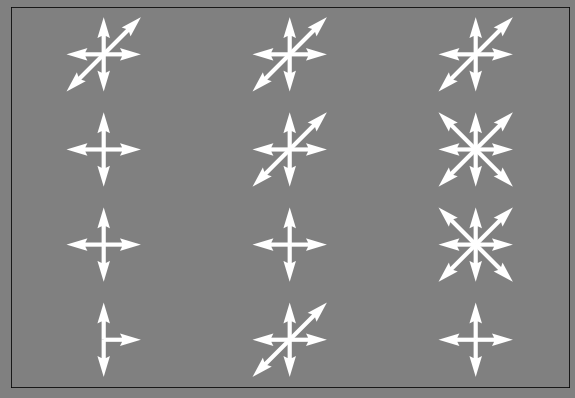

In [6]:
plt.figure(figsize=(10,7), facecolor='gray')

for idx, row in loc_dir.iterrows():
    origin = np.repeat(np.array([[row.x],[row.y]]),row.num_dir, axis=-1)
    V = np.array([eval(s) for s in row.dir_xy])
    
    plt.quiver(*origin, V[:,0], V[:,1], scale=15, color='white')
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,3.5)
plt.xticks([])
plt.yticks([])
plt.show()

## A hora

### Há exatamente 13.059 observações para cada via durante o período de 0h de 01 de abril a 11h40 de 30 de setembro de 1991. Com uma observação por 20 minutos, há 13.140 instantes de observação nesse período. Portanto, há 81 observações faltantes por estrada que perfazem até 81 x 65 = 5265 observações faltantes.

In [7]:
print(train.groupby(['x', 'y', 'direction']).time.count())
print(f'Total time instants within the observation period: {int(train.time_id.max() - train.time_id.min()+1)}')

x  y  direction
0  0  EB           13059
      NB           13059
      SB           13059
   1  EB           13059
      NB           13059
                   ...  
2  3  NB           13059
      NE           13059
      SB           13059
      SW           13059
      WB           13059
Name: time, Length: 65, dtype: int64
Total time instants within the observation period: 13140


### Os 5265 instantes que faltam podem ser preenchidos conforme abaixo

In [8]:
time = pd.DataFrame(pd.date_range('1991-04-01 00:00:00', '1991-09-30 11:40:00', freq='20Min'), columns=['time'])

dfs = []
for group in train.groupby(['x', 'y', 'direction']):
    dfs.append(group[1].merge(time, on='time', how= 'right'))

train_new = pd.concat(dfs, axis=0).sort_values(['time', 'x', 'y', 'direction']).reset_index()
print(f'Missing row:\n{train_new.isna().sum()}')

Missing row:
index            0
time             0
x             5265
y             5265
direction     5265
congestion    5265
time_id       5265
dir_xy        5265
dtype: int64


## O alvo 
### nível de congestionamento

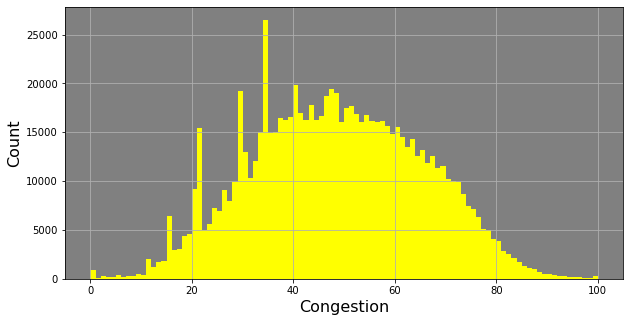

In [9]:
# Histogram
plt.figure(figsize=(10,5))
train.congestion.hist(bins=100, color='yellow')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

### Manhã vs Tarde

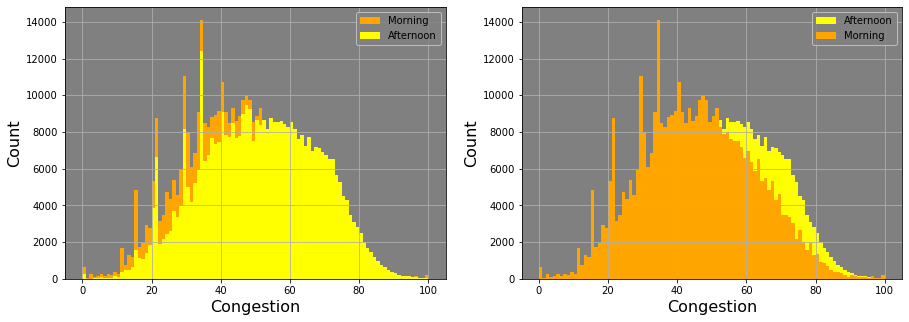

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
train[train.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.subplot(1,2,2)
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
train[train.time.dt.hour<12].congestion.hist(bins=100, color='orange', label='Morning')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.show()

### Se adicionarmos 5 unidades de congestionamento aos dados da manha, sua distribuição se encaixa muito bem com a da tarde

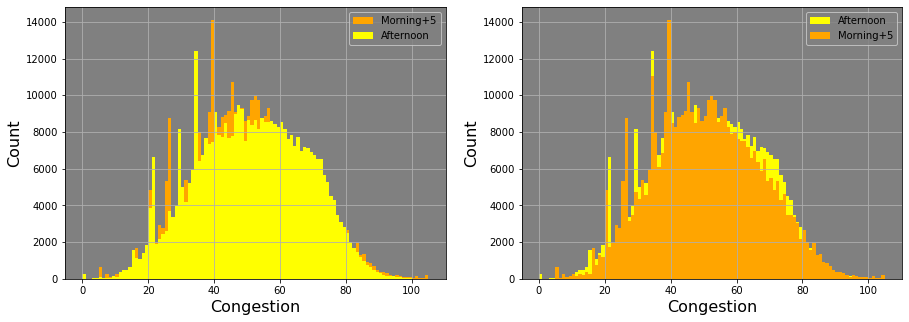

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
(train[train.time.dt.hour<12].congestion+5).hist(bins=100, color='orange', label='Morning+5')
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.subplot(1,2,2)
train[train.time.dt.hour>=12].congestion.hist(bins=100, color='yellow', label='Afternoon')
(train[train.time.dt.hour<12].congestion+5).hist(bins=100, color='orange', label='Morning+5')
plt.xlabel('Congestion', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.legend()

plt.show()

## Histogramas para cada estrada

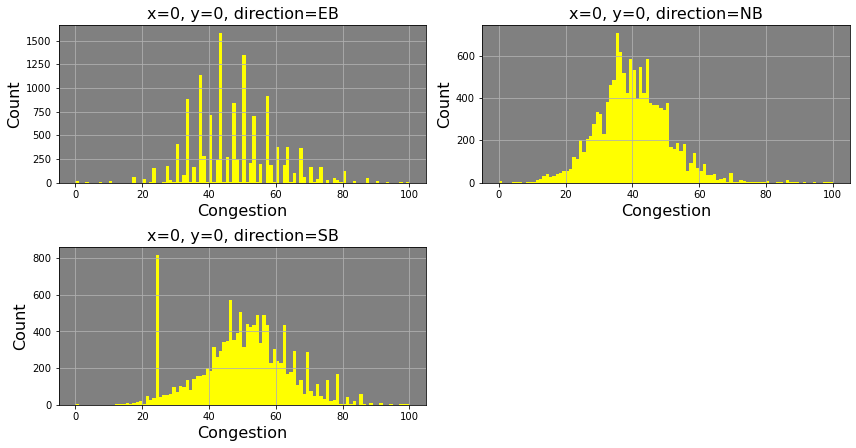

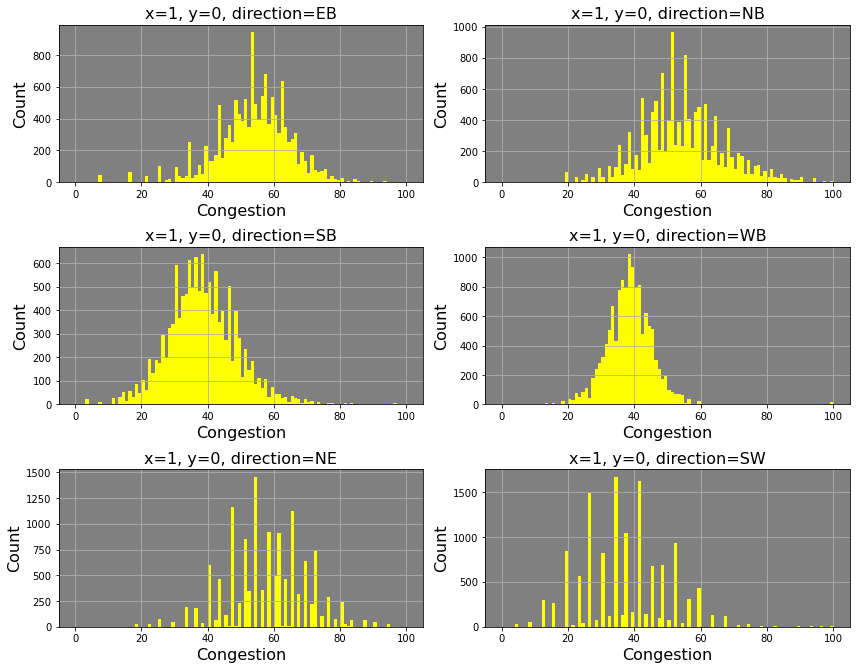

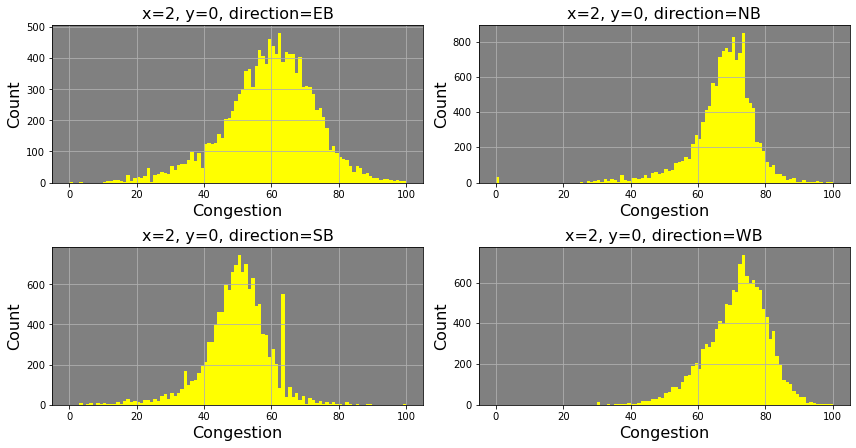

In [12]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,12))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:
                plt.subplot(4,2,idx+1)
                df.congestion.hist(bins=100, color='yellow')
                plt.title(f'x={x}, y={y}, direction={direction}', fontsize=16)
                plt.xlabel('Congestion', fontsize=16)
                plt.ylabel('Count', fontsize=16)
                plt.tight_layout()
            
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Correlação entre 12 locais

### Algumas fortes correlações de congestionamento podem ser observadas entre os locais. Por exemplo, a localização x=1, y=2 e aquela com x=1 e y=3 têm um alto coeficiente de correlação de 0,79.

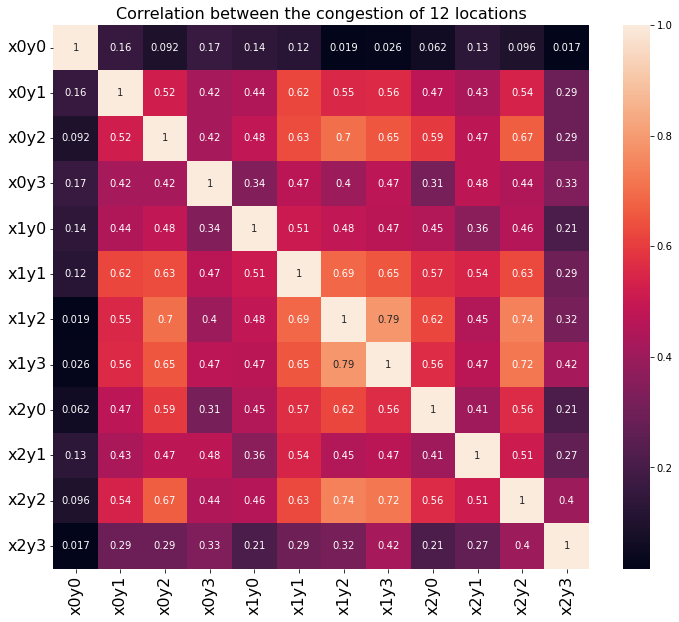

In [13]:
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.figure(figsize=(12,10))
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the congestion of 12 locations', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.show()

## Correlação entre 12 locais em dois instantes consecutivos

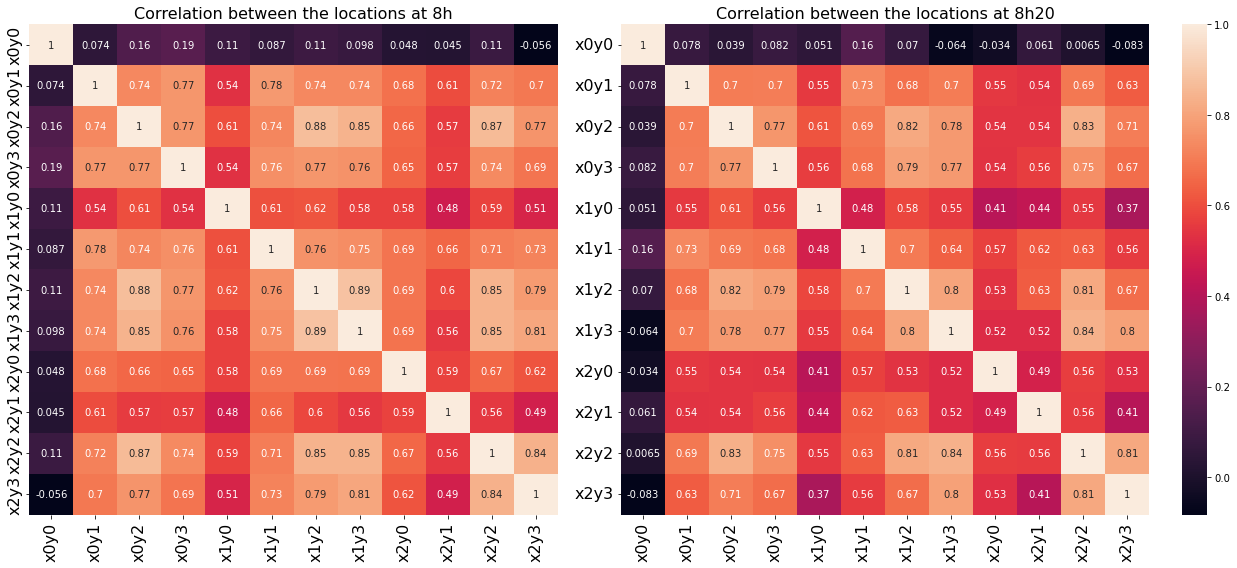

In [14]:
plt.figure(figsize=(18,8))

# At 12h
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y) & (train.time.dt.hour==8) & (train.time.dt.minute==0)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1,2,1)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=90, fontsize=16)
plt.tight_layout()

# At 12h20'
dfs = []
columns = []
for x in range(3):
    for y in range(4):
        df = train[(train.x == x) & (train.y==y) & (train.time.dt.hour==8) & (train.time.dt.minute==20)]
        dfs.append(df.groupby('time').congestion.mean().tolist())
        columns.append(f'x{x}y{y}')      
location_congestions = pd.DataFrame(np.array(dfs).T, columns=columns)

plt.subplot(1,2,2)
sns.heatmap(location_congestions.corr(), annot=True)
plt.title('Correlation between the locations at 8h20', fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()

plt.show()

## Correlação diária entre os locais (x,y)=(1,2) e (1,3)

### Esses dois locais parecem estar altamente conectados durante as horas de pico (8h e 17h).

In [15]:
train['daytime_id'] = ( (train.time.dt.hour*60+train.time.dt.minute) /20 ).astype(int)

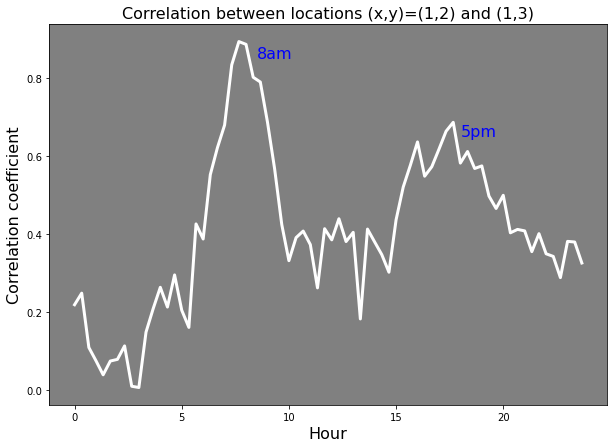

In [16]:
corrs = []
for daytime_id in train.daytime_id.unique():
    loc_12 = train[(train.x == 1) & (train.y==2) & (train.daytime_id==daytime_id)].groupby('time').congestion.mean().tolist()
    loc_13 = train[(train.x == 1) & (train.y==3) & (train.daytime_id==daytime_id)].groupby('time').congestion.mean().tolist()
    corr = pd.DataFrame(np.array([loc_12, loc_13]).T).corr()[0][1]
    corrs.append(corr)
    
plt.figure(figsize=(10,7))
plt.plot(train.daytime_id.unique()/3.0, corrs, 'white', linewidth=3)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)
plt.title('Correlation between locations (x,y)=(1,2) and (1,3)', fontsize=16)
plt.text(8.5, 0.85, '8am', color='blue', fontsize=16)
plt.text(18, 0.65, '5pm', color='blue', fontsize=16)
plt.show()

## Correlação entre diferentes direções em cada local

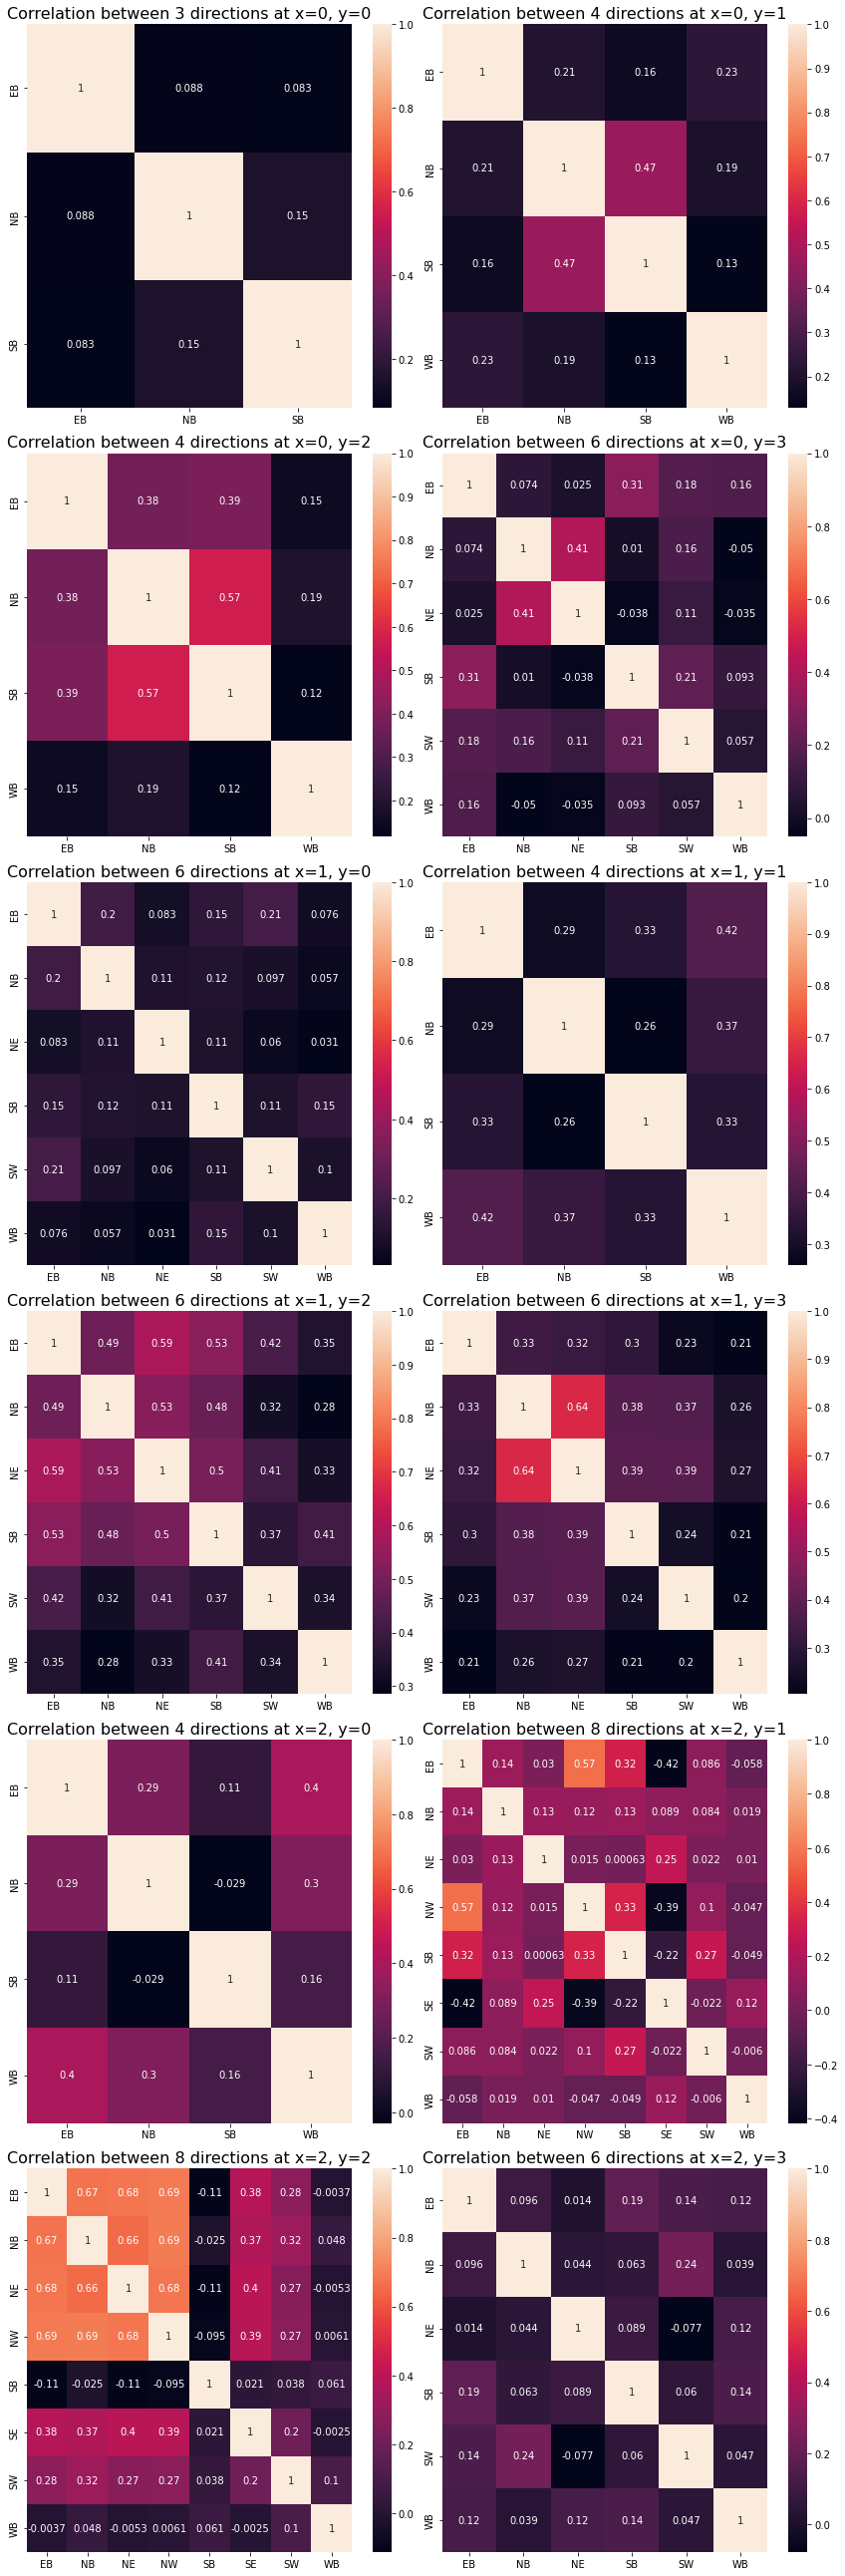

In [17]:
plt.figure(figsize=(12,36))
for x in range(3):
    for y in range(4):
        dfs = []
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                dfs.append(df.congestion.tolist())
                
        roadway_congestions = pd.DataFrame(np.array(dfs).T, columns=train[(train.x == x) & (train.y==y)].direction.unique())
        
        plt.subplot(6,2,4*x+y+1)
        sns.heatmap(roadway_congestions.corr(), annot=True)
        plt.title(f'Correlation between {len(dfs)} directions at x={x}, y={y}', fontsize=16)
        plt.tight_layout()
plt.show()

## Congestionamento médio por mês

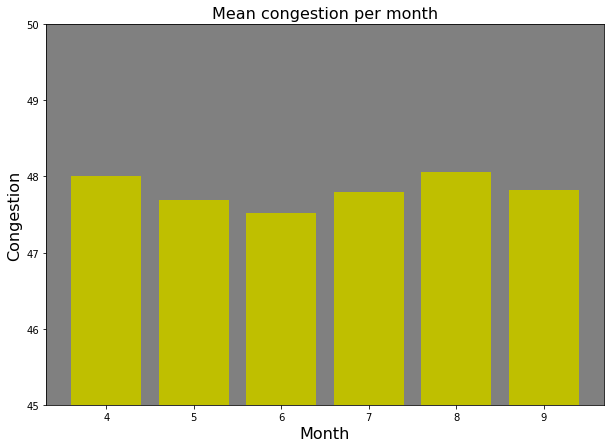

In [18]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.month.unique(), train.groupby(train.time.dt.month).congestion.mean(), color='y')
plt.title(f'Mean congestion per month', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

## Congestionamento médio por mês para cada rodovia

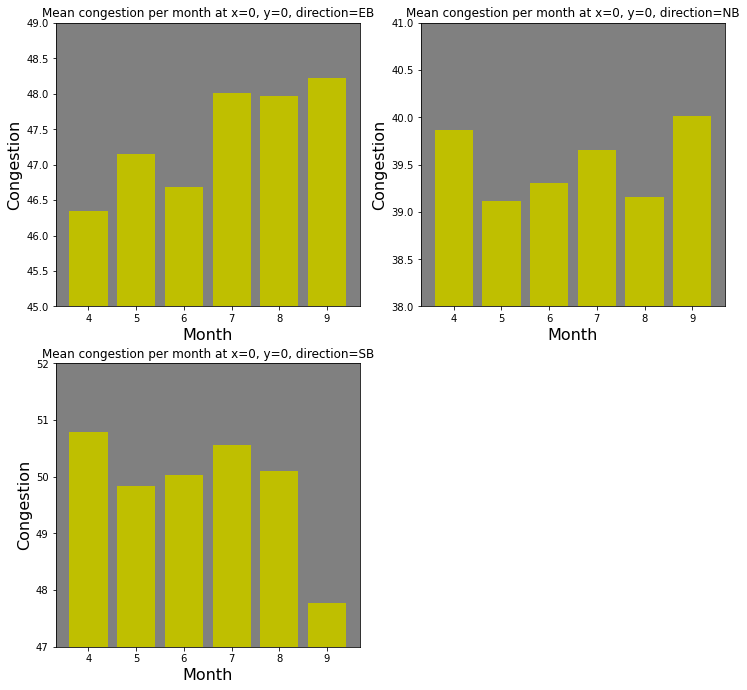

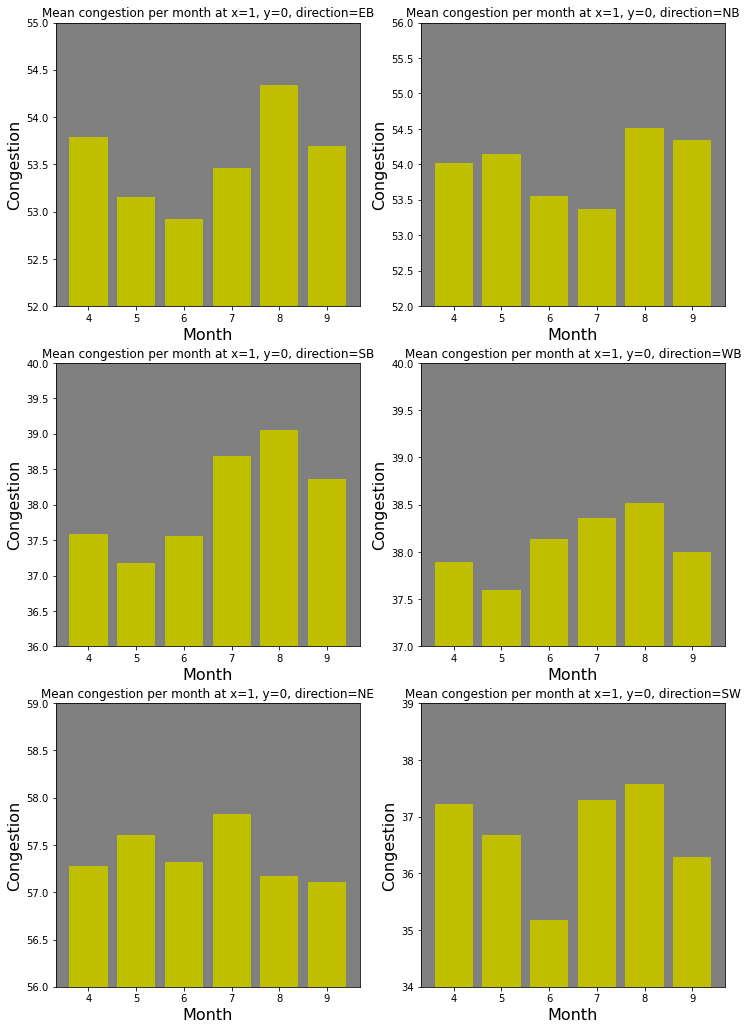

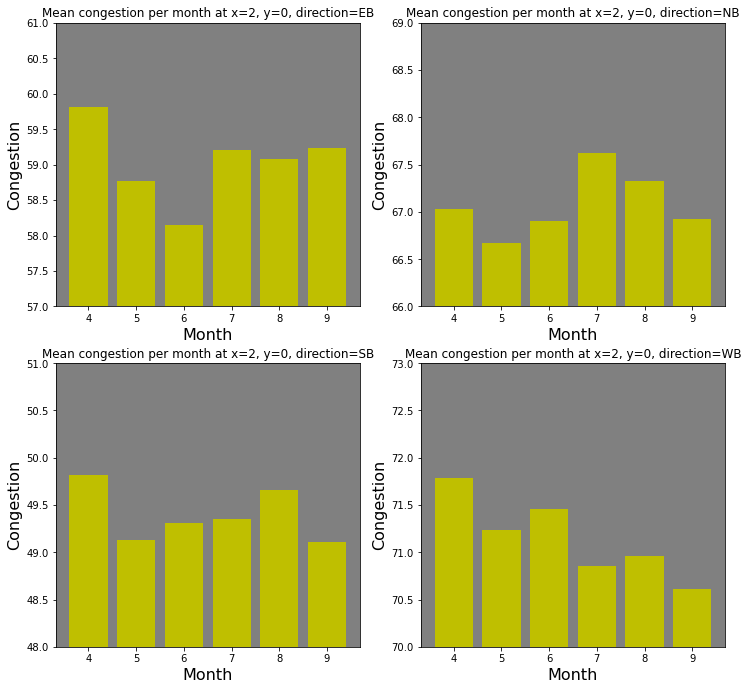

In [19]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.month.unique(), df.groupby(df.time.dt.month).congestion.mean(), color='y')
                plt.title(f'Mean congestion per month at x={x}, y={y}, direction={direction}')
                plt.xlabel('Month', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.month).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.month).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento mensal médio 

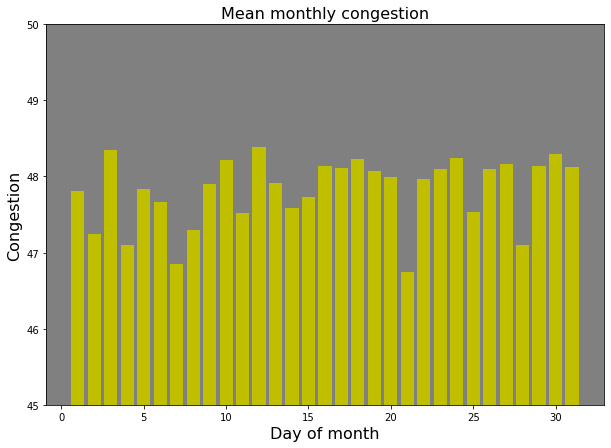

In [20]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.day.unique(), train.groupby(train.time.dt.day).congestion.mean(), color='y')
plt.title(f'Mean monthly congestion', fontsize=16)
plt.xlabel('Day of month', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

## Congestionamento mensal médio para cada via

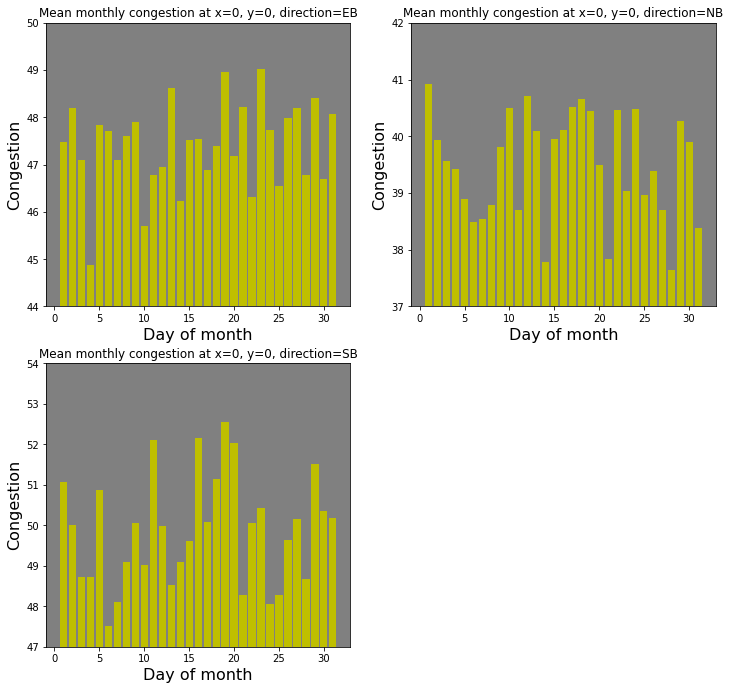

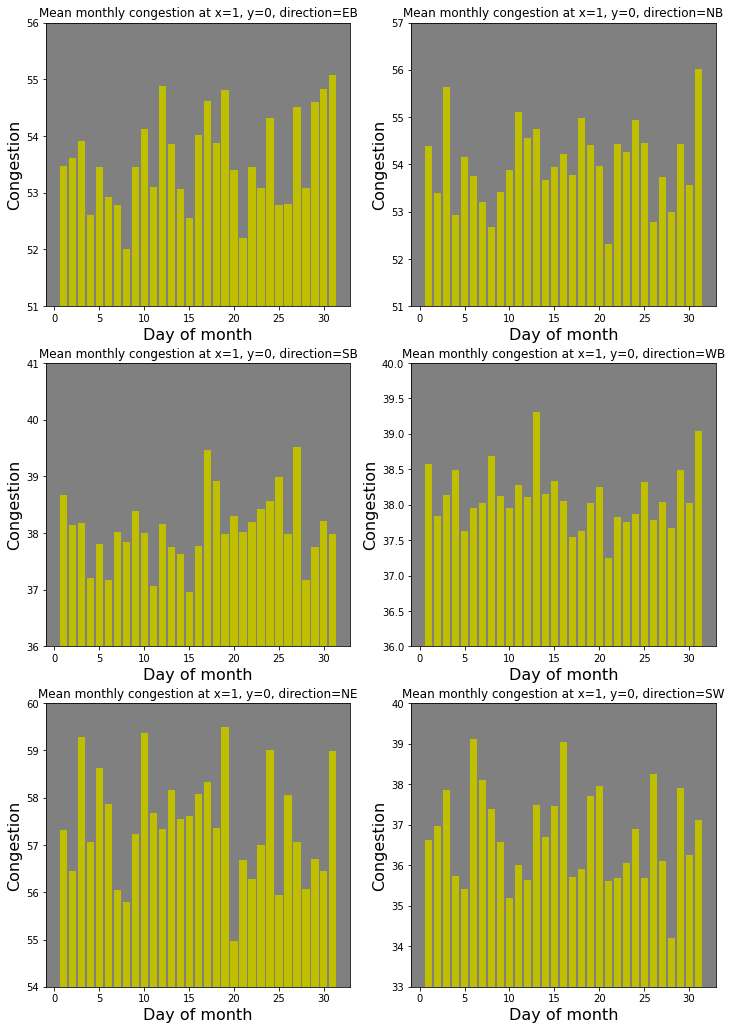

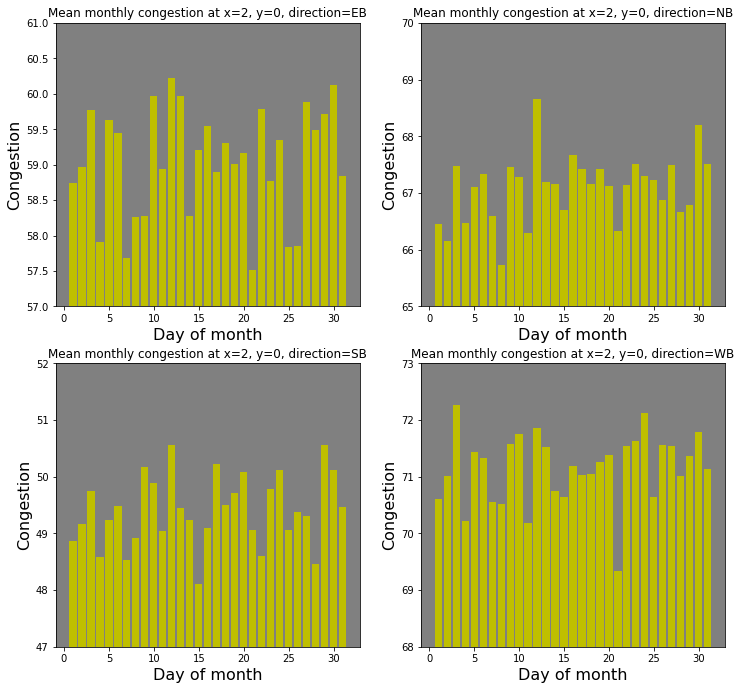

In [21]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.day.unique(), df.groupby(df.time.dt.day).congestion.mean(), color='y')
                plt.title(f'Mean monthly congestion at x={x}, y={y}, direction={direction}')
                plt.xlabel('Day of month', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.day).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.day).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento médio por semana

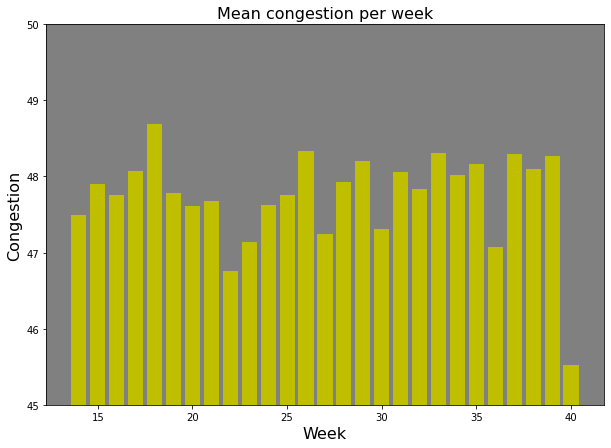

In [22]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.week.unique(), train.groupby(train.time.dt.week).congestion.mean(), color='y')
plt.title(f'Mean congestion per week', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(45,50)
plt.show()

## Congestionamento médio por semana para cada rodovia

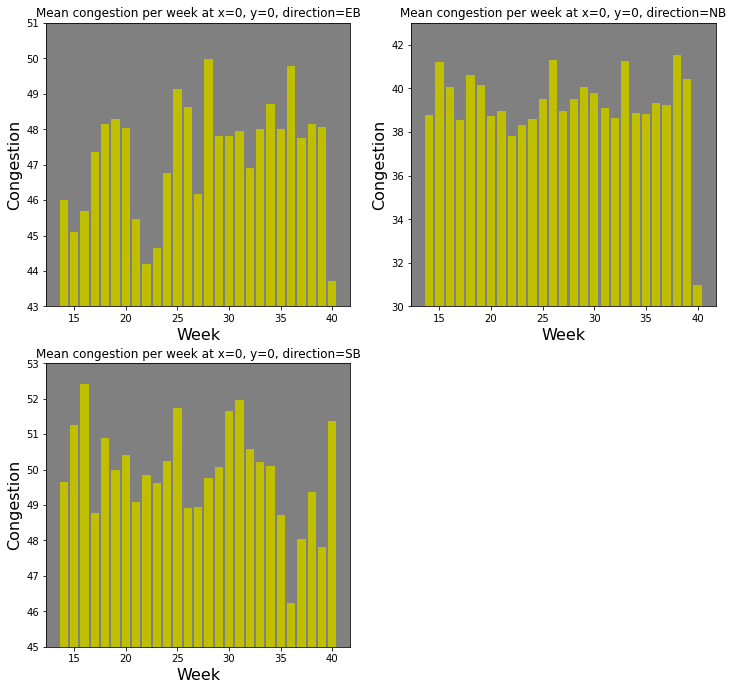

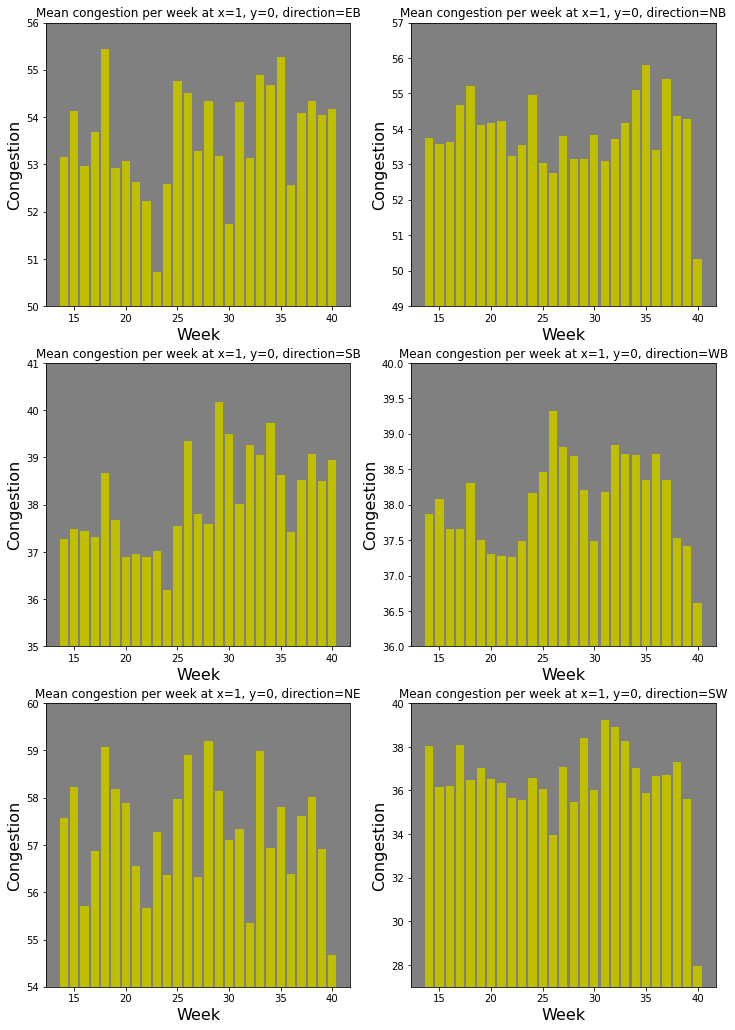

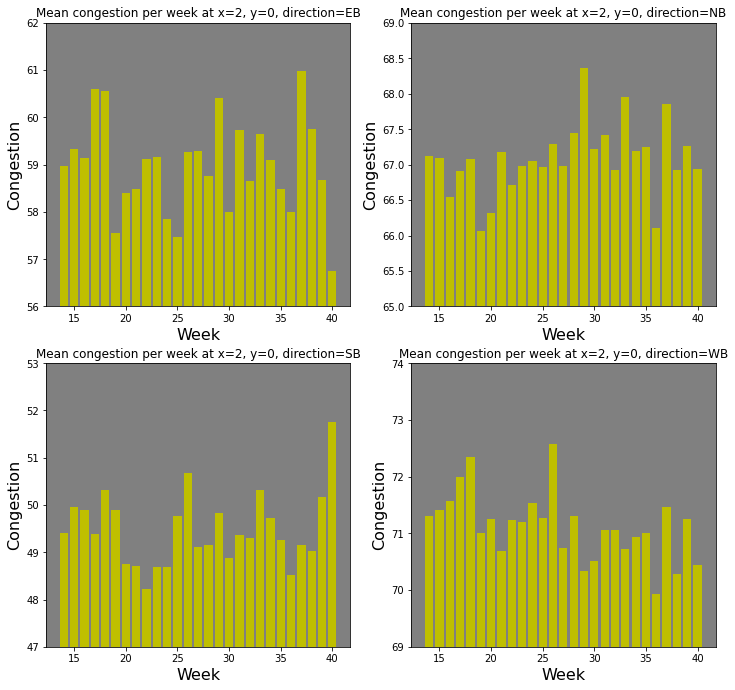

In [23]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.week.unique(), df.groupby(df.time.dt.week).congestion.mean(), color='y')
                plt.title(f'Mean congestion per week at x={x}, y={y}, direction={direction}')
                plt.xlabel('Week', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.week).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.week).congestion.mean().round().astype(int).max()+1)
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento semanal médio

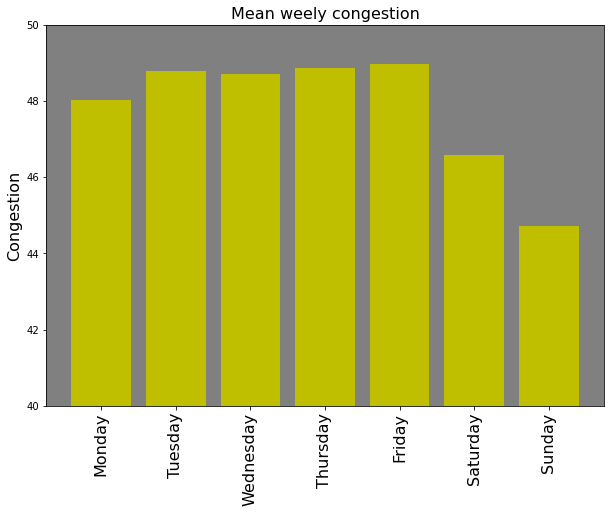

In [24]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.weekday.unique(), train.groupby(train.time.dt.weekday).congestion.mean(), color='y')
plt.title(f'Mean weely congestion', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=16, rotation=90)
plt.ylim(40,50)
plt.show()

## Congestionamento semanal médio para cada via

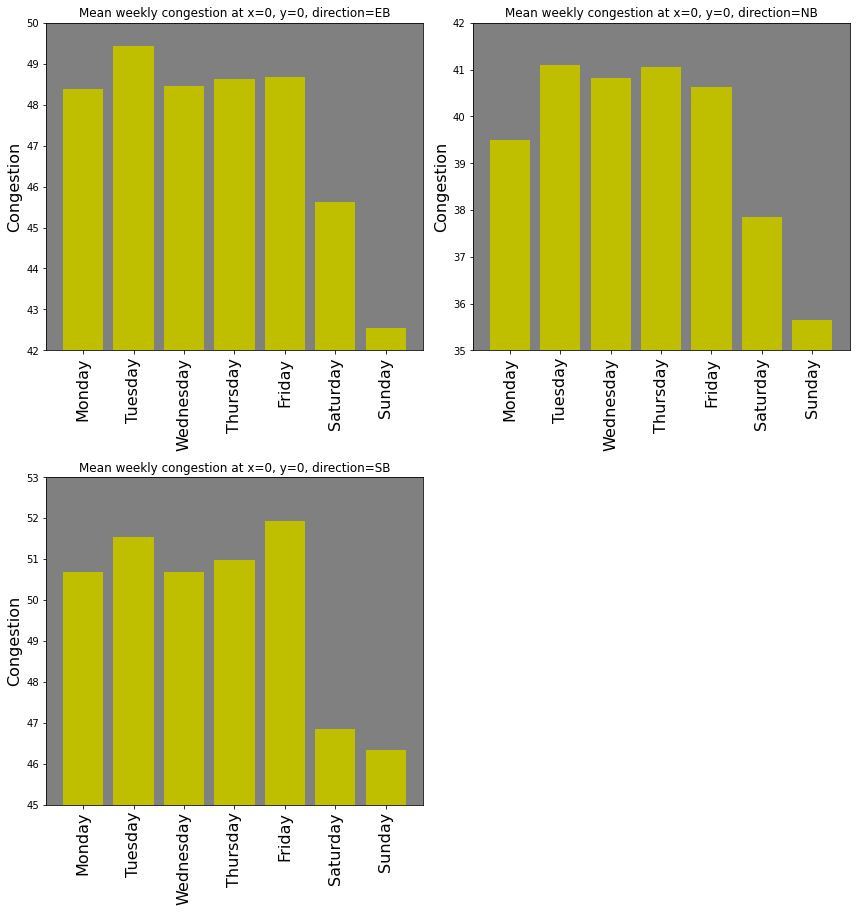

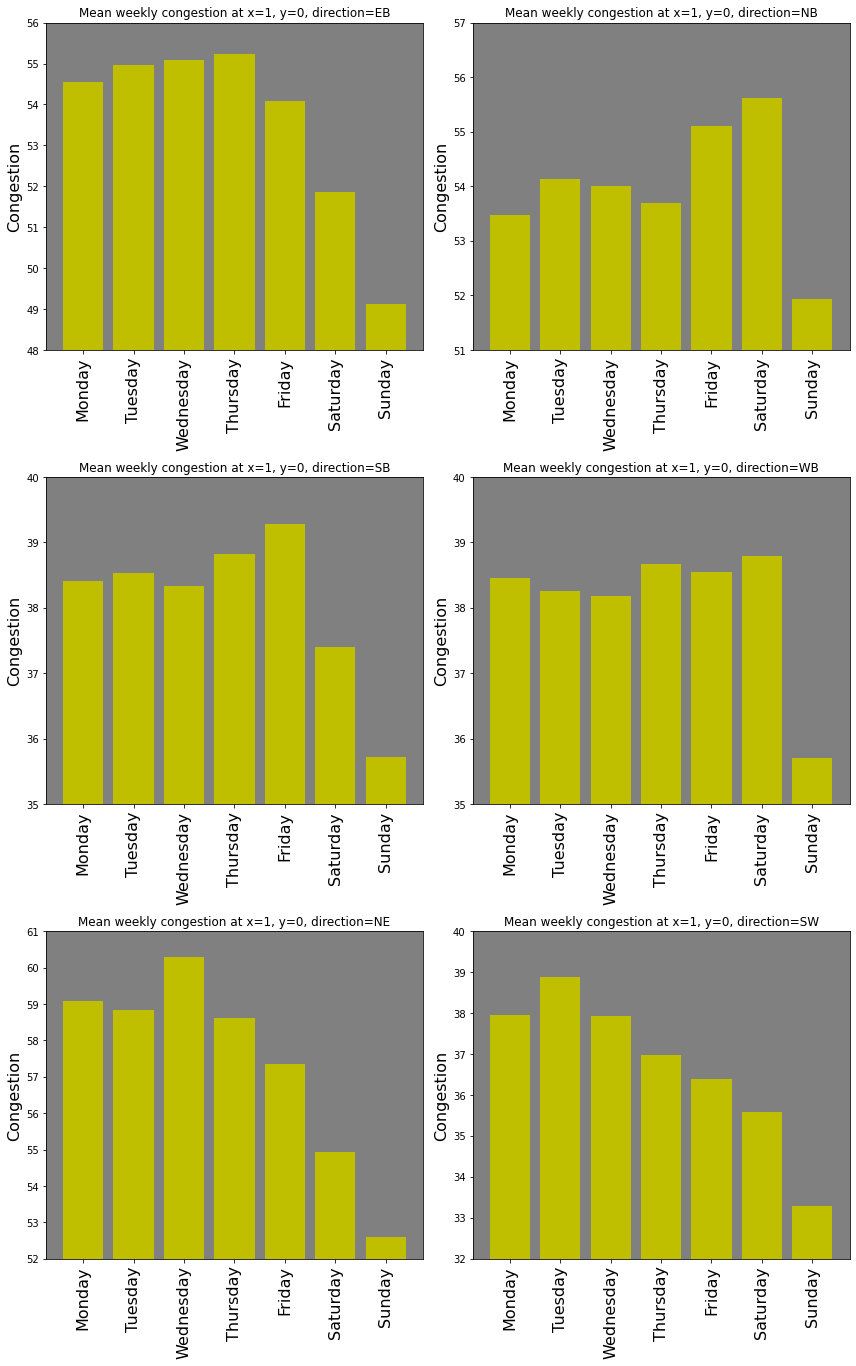

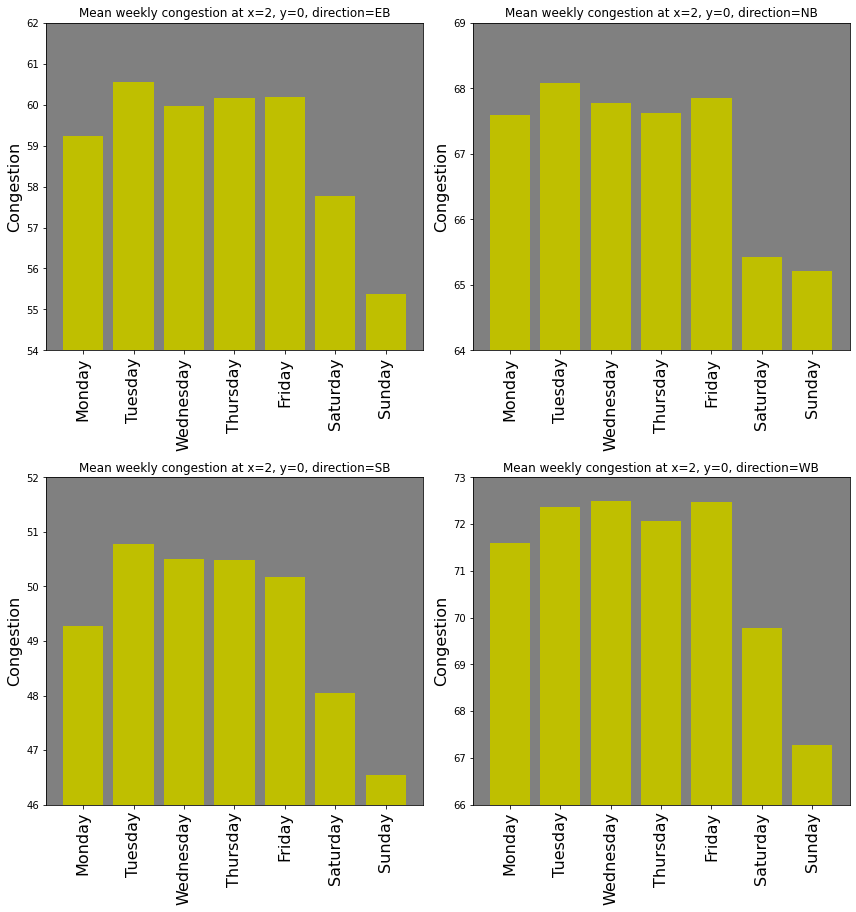

In [25]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.weekday.unique(), df.groupby(df.time.dt.weekday).congestion.mean(), color='y')
                plt.title(f'Mean weekly congestion at x={x}, y={y}, direction={direction}')
                plt.ylabel('Congestion', fontsize=16)
                plt.ylim(df.groupby(df.time.dt.weekday).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.weekday).congestion.mean().round().astype(int).max()+1)
                plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=16, rotation=90)
                plt.tight_layout()
        plt.show()
                
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento médio por dia

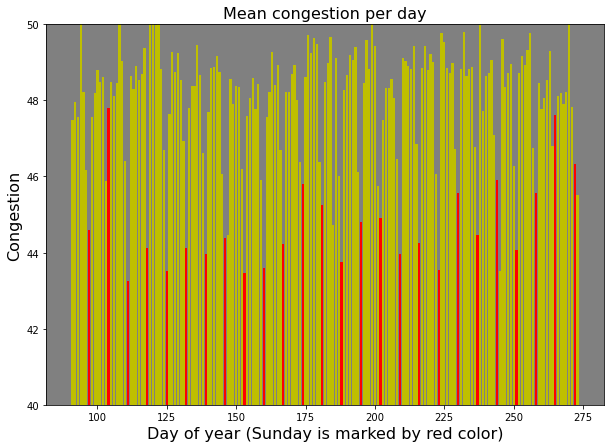

In [26]:
plt.figure(figsize=(10,7))
plt.bar(train.time.dt.dayofyear.unique(), train.groupby(train.time.dt.dayofyear).congestion.mean(), color=['r' if (int(day)%7)==6 else 'y' for day in train.time.dt.dayofyear.unique()])
plt.title(f'Mean congestion per day', fontsize=16)
plt.xlabel('Day of year (Sunday is marked by red color)', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.ylim(40,50)
plt.show()

## Congestionamento médio por dia para cada via

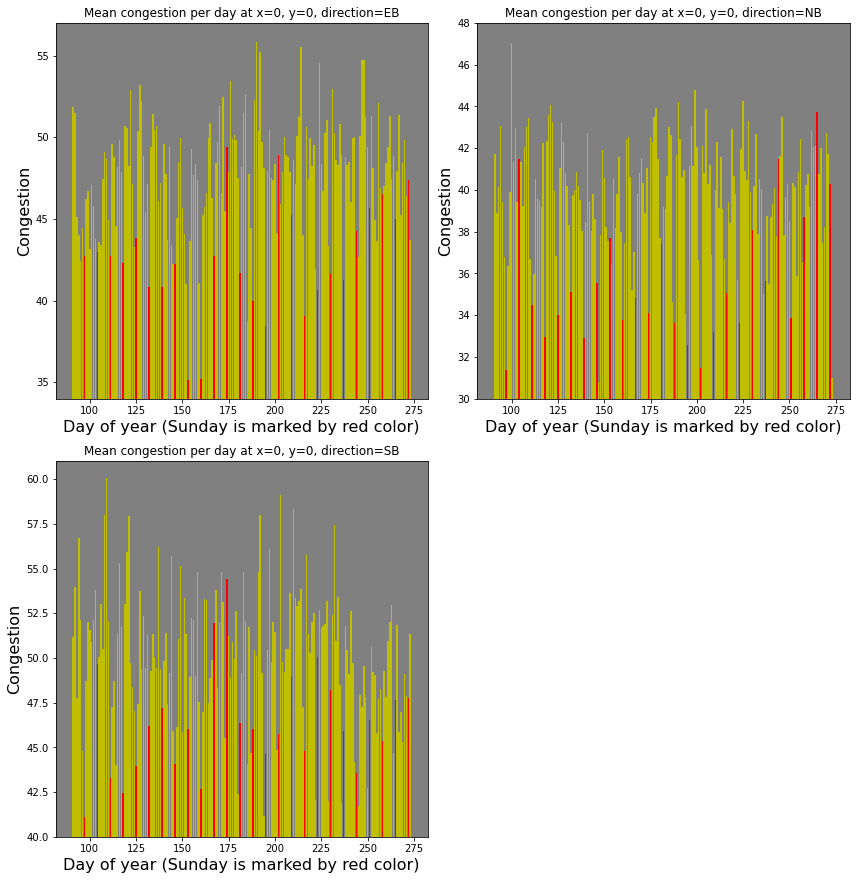

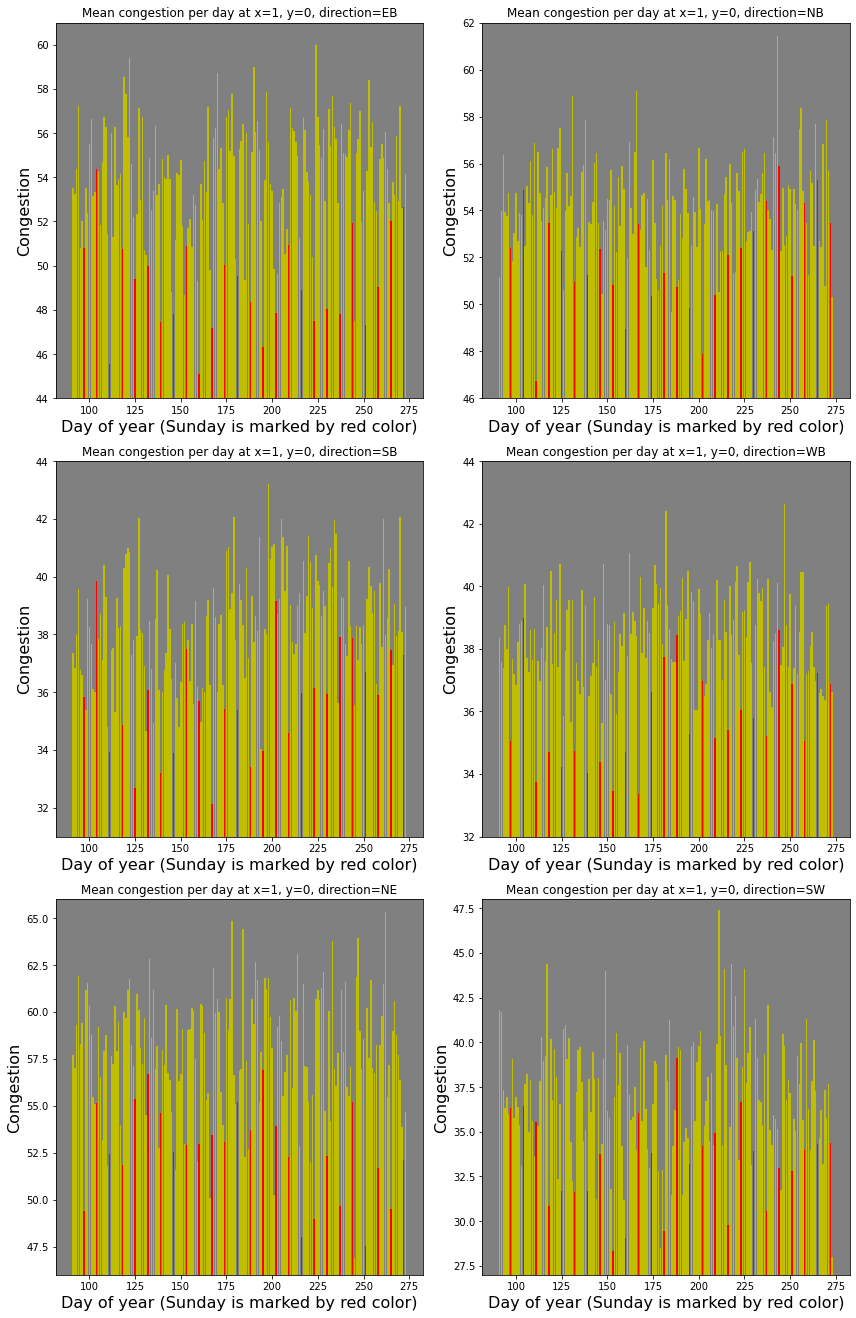

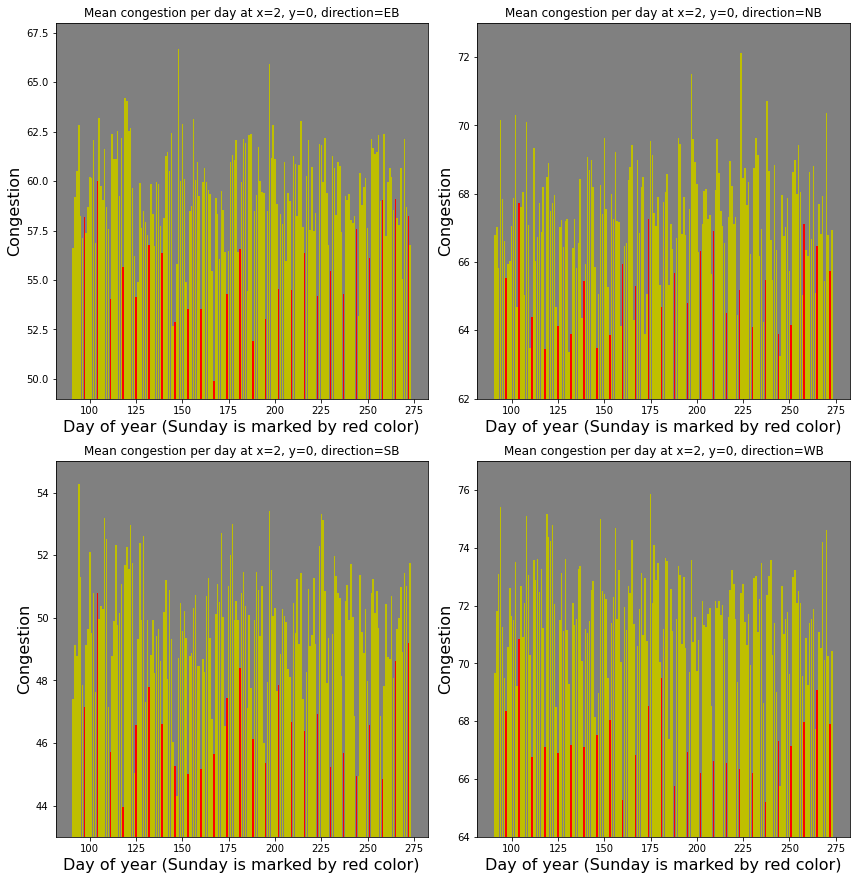

In [27]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.bar(df.time.dt.dayofyear.unique(), df.groupby(df.time.dt.dayofyear).congestion.mean(), color=['r' if (int(day)%7)==6 else 'y' for day in train.time.dt.dayofyear.unique()])
                plt.title(f'Mean congestion per day at x={x}, y={y}, direction={direction}')
                plt.xlabel('Day of year (Sunday is marked by red color)', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)                
                plt.ylim(df.groupby(df.time.dt.dayofyear).congestion.mean().round().astype(int).min()-1, df.groupby(df.time.dt.dayofyear).congestion.mean().round().astype(int).max()+1)
                plt.tight_layout()
        plt.show()
                
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento diário médio

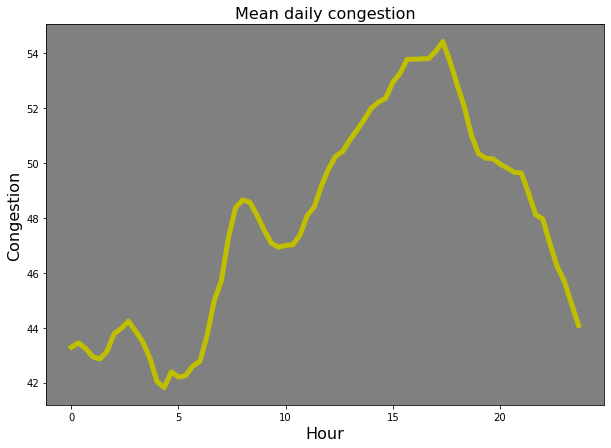

In [28]:
plt.figure(figsize=(10,7))
plt.plot(train.groupby(train.daytime_id).daytime_id.unique()/3.0, train.groupby(train.daytime_id).congestion.mean(), 'y', linewidth=5)
plt.title(f'Mean daily congestion', fontsize=16)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.show()

## Congestionamento diário médio para cada via

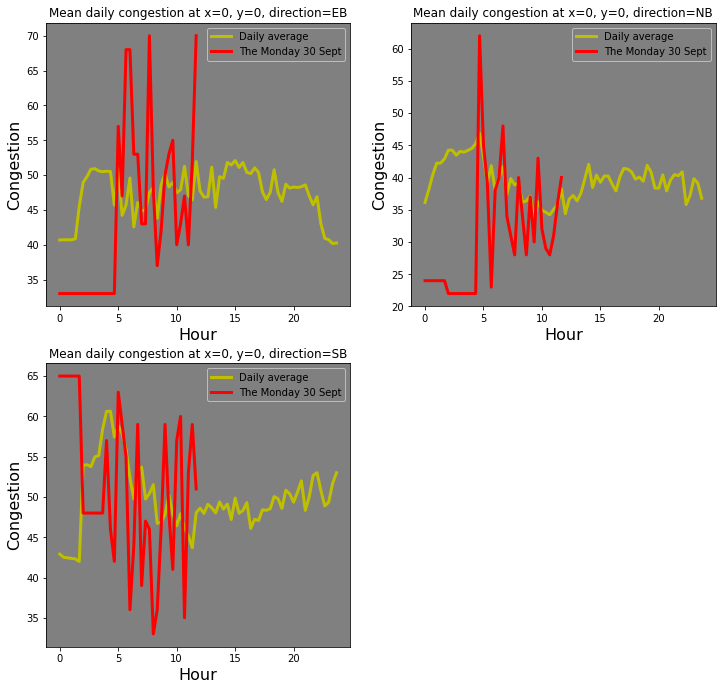

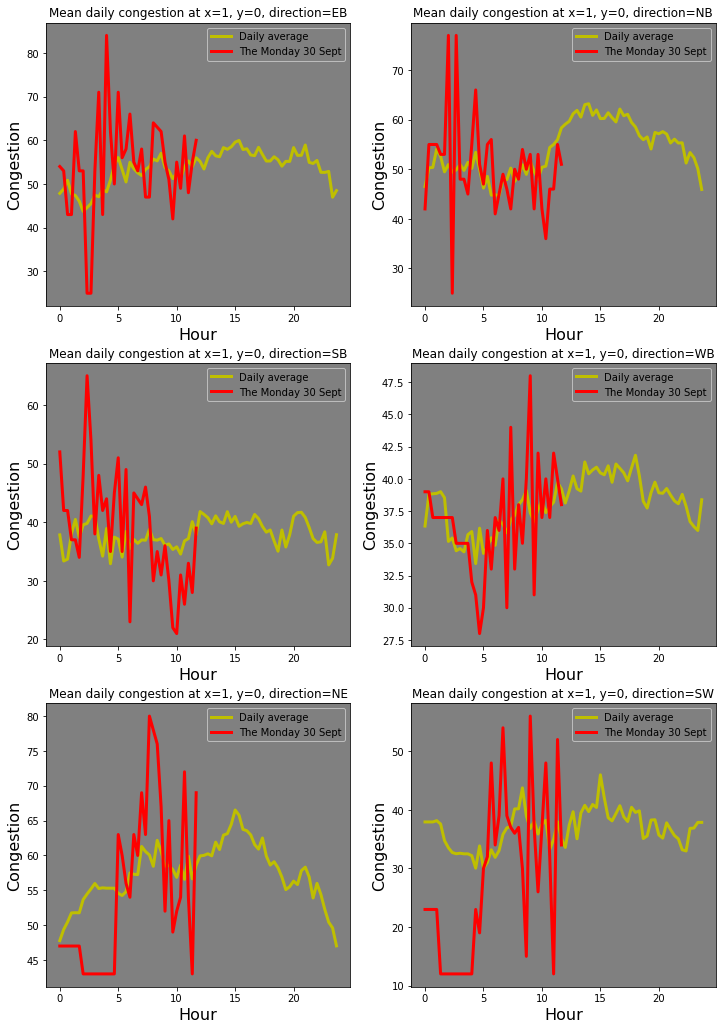

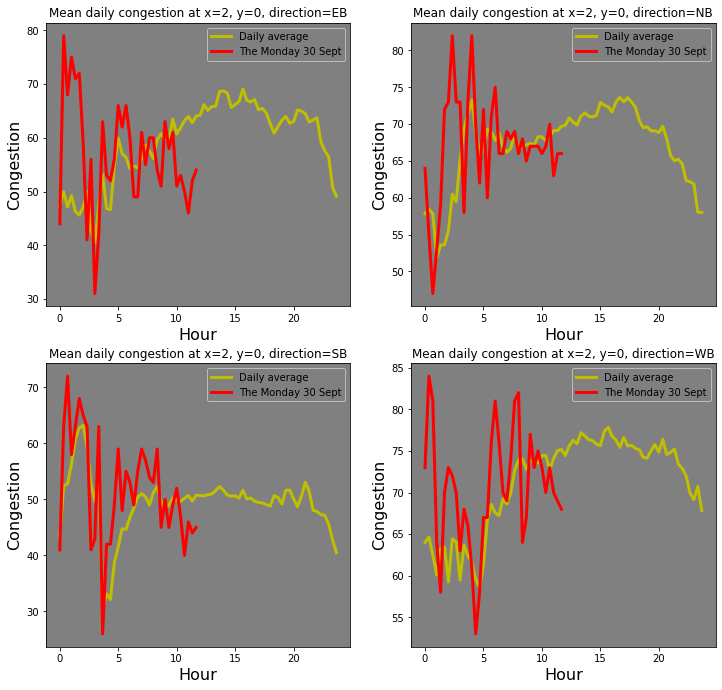

In [29]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.mean(), 'y', linewidth=3, label='Daily average')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'Mean daily congestion at x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Congestionamento médio de segunda-feira 

### Em 30 de setembro de 1991, onde localizar o conjunto de teste é uma segunda-feira. É de interesse examinar os dados deste dia da semana.

In [30]:
df = train[train.time.dt.weekday==0]

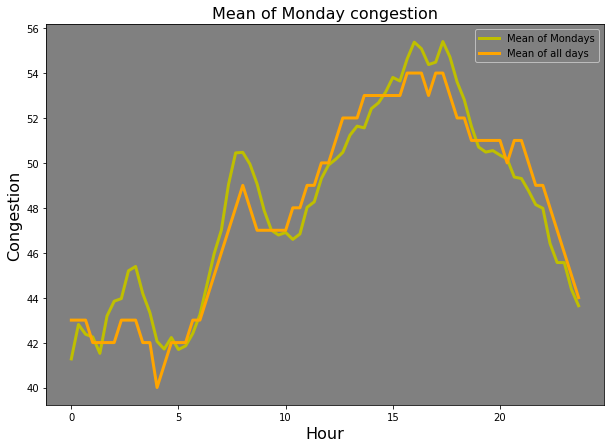

In [31]:
plt.figure(figsize=(10,7))
plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.mean(), 'y', linewidth=3, label='Mean of Mondays')

plt.plot(train.groupby(train.daytime_id).daytime_id.unique()/3.0, train.groupby(train.daytime_id).congestion.median(), 'orange', linewidth=3, label='Mean of all days')
plt.title(f'Mean of Monday congestion', fontsize=16)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Congestion', fontsize=16)
plt.legend()
plt.show()

## Congestionamento médio de segunda-feira para cada estrada

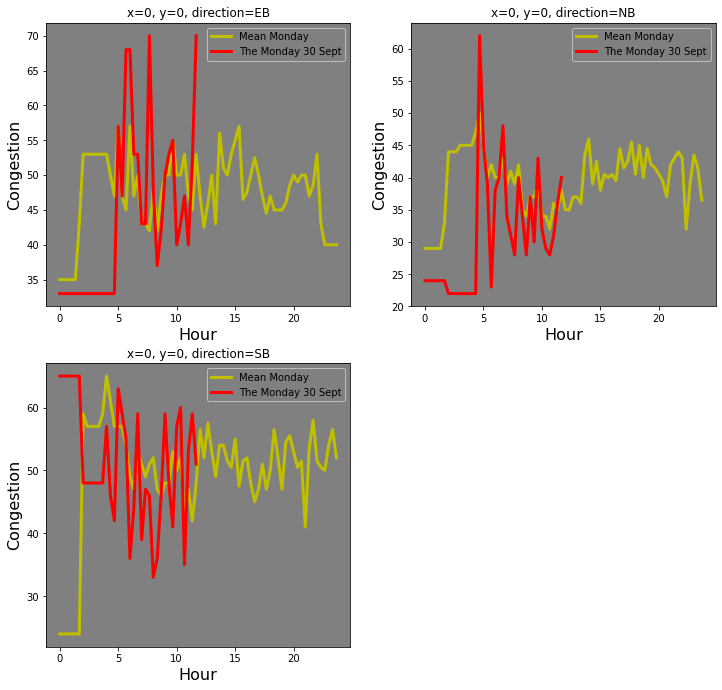

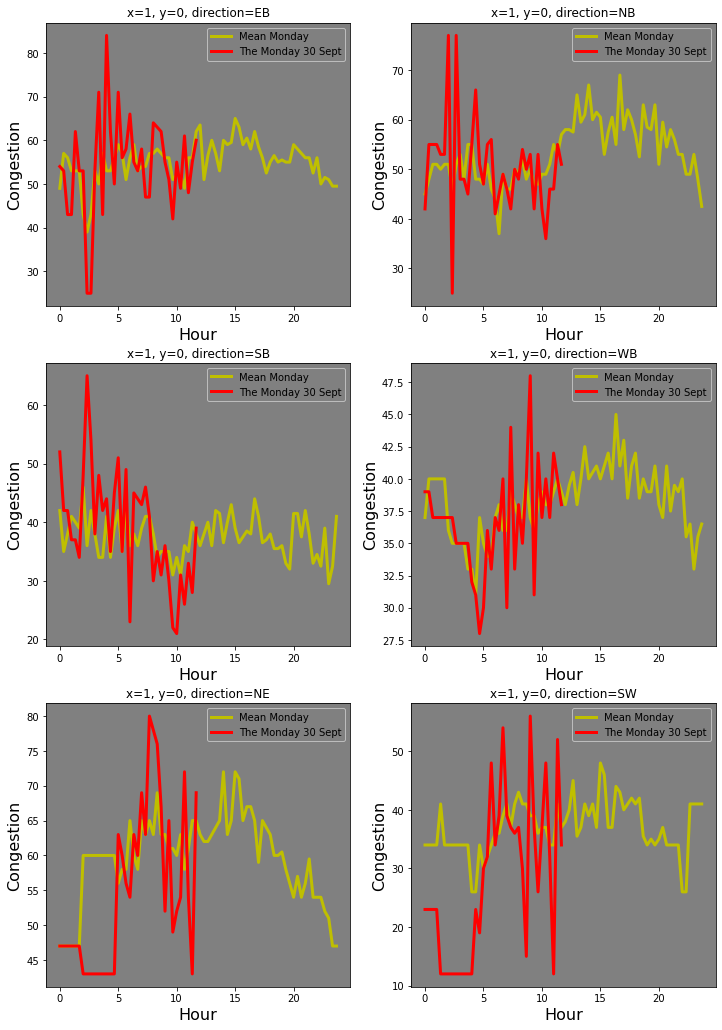

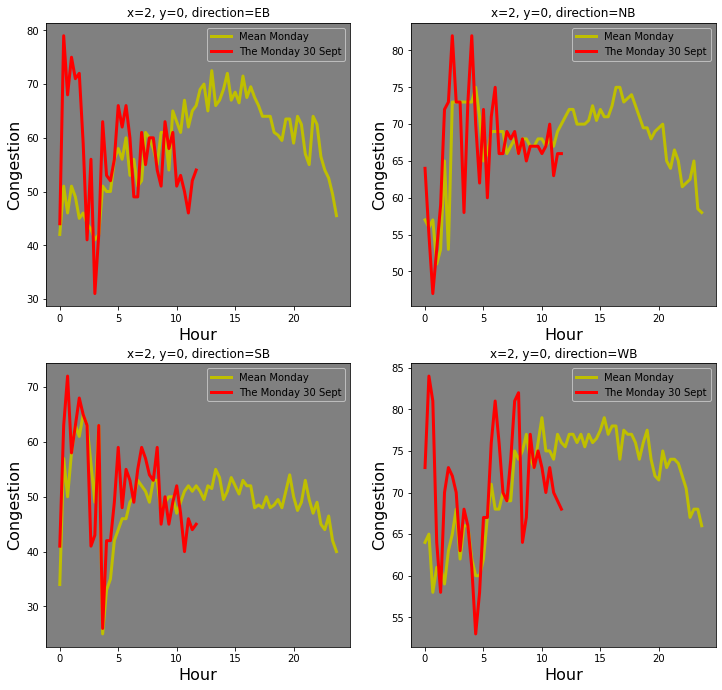

In [32]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df.groupby(df.daytime_id).daytime_id.unique()/3.0, df.groupby(df.daytime_id).congestion.median(), 'y', linewidth=3, label='Mean Monday')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## A segunda-feira mais próxima, 23 de setembro

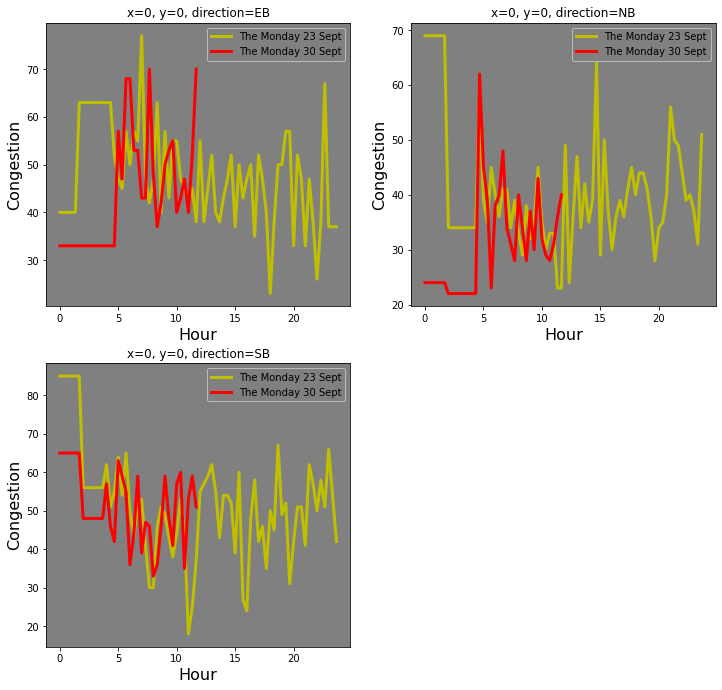

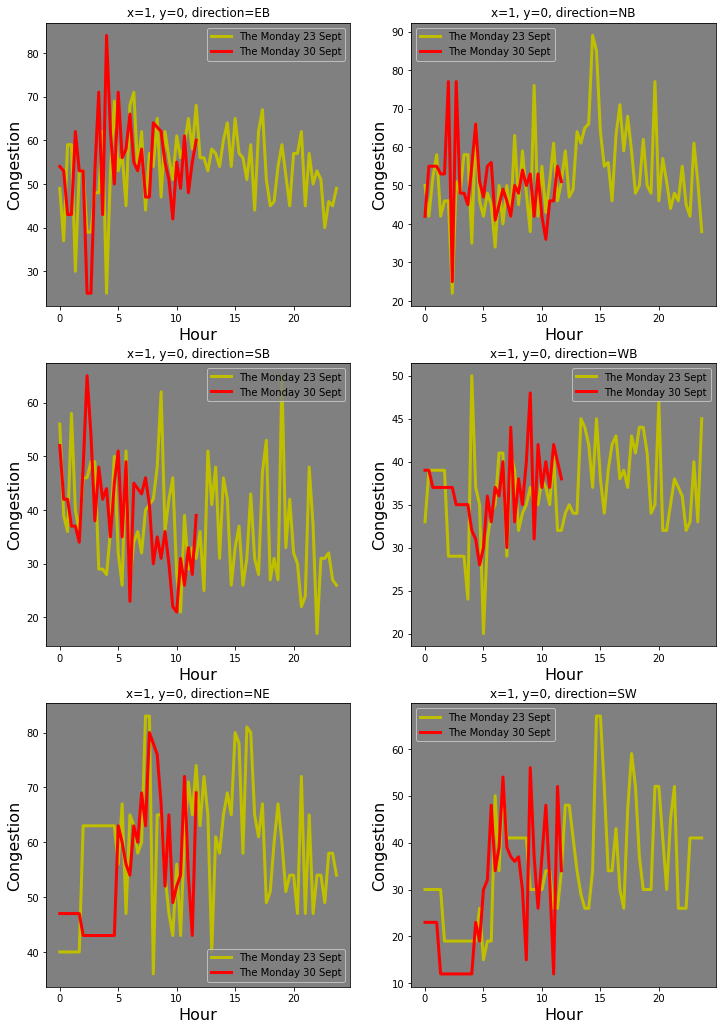

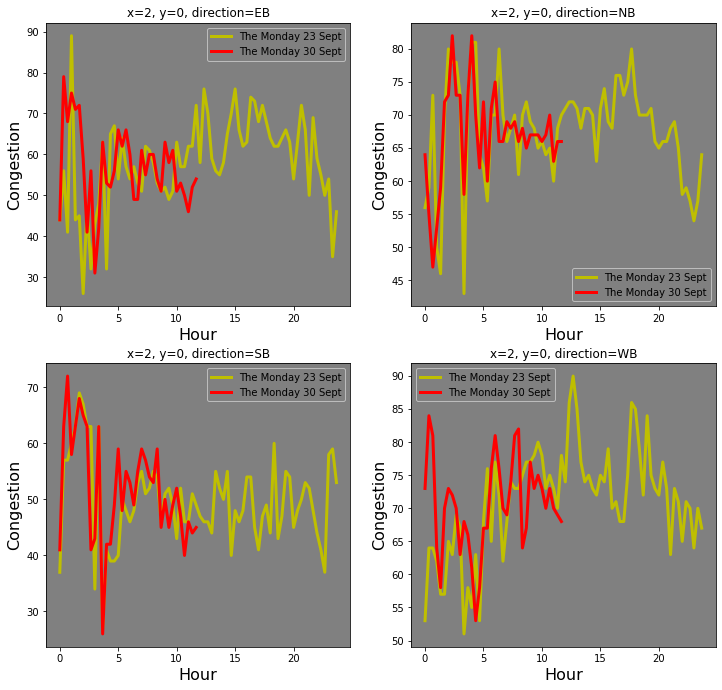

In [33]:
for x in range(3):
    for y in range(4):
        plt.figure(figsize=(12,24))
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each location and direction
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                plt.subplot(4,2,idx+1)
                plt.plot(df[train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7].daytime_id/3.0, df[train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7].congestion, 'y', linewidth=3, label='The Monday 23 Sept')
                plt.plot(df[-36:].daytime_id/3.0, df[-36:].congestion, 'r', linewidth=3, label='The Monday 30 Sept')
                plt.title(f'x={x}, y={y}, direction={direction}')
                plt.xlabel('Hour', fontsize=16)
                plt.ylabel('Congestion', fontsize=16)
                plt.legend()
        plt.show()
        
        print('\n\n')
        break # remover pausa para plotar para todas as 65 estradas

## Correlação entre os dias

In [34]:
train_new.congestion = train_new.congestion.fillna(train_new.congestion.mean())

In [35]:
congestion = pd.DataFrame(np.array(train_new.congestion).reshape(365,2340).T)
congestion_morning = congestion[[col for col in congestion.columns if col%2==0]]
congestion_afternoon = congestion[[col for col in congestion.columns if col%2==1]]
congestion_monday_afternoon = congestion[[col for col in congestion.columns if col%14==1]].round().astype(int)
congestion_monday_afternoon_smoothed = congestion_monday_afternoon.rolling(10, min_periods=1).mean()

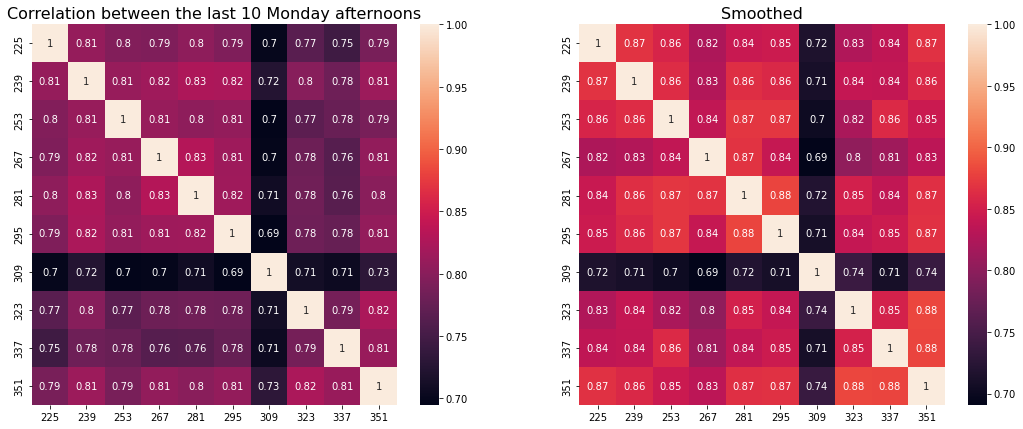

In [36]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
sns.heatmap(congestion_monday_afternoon[congestion_monday_afternoon.columns[-10:]].corr(), annot=True)
plt.title('Correlation between the last 10 Monday afternoons', fontsize=16)

plt.subplot(1,2,2)
sns.heatmap(congestion_monday_afternoon_smoothed[congestion_monday_afternoon_smoothed.columns[-10:]].corr(), annot=True)
plt.title('Smoothed', fontsize=16)

plt.show()

## Pontuação entre o congestionamento das tardes de segunda-feira
### Abaixo, calculo o erro absoluto médio entre todas as tardes de segunda-feira e a tarde de segunda-feira mais próxima do teste (o dia 23 de setembro

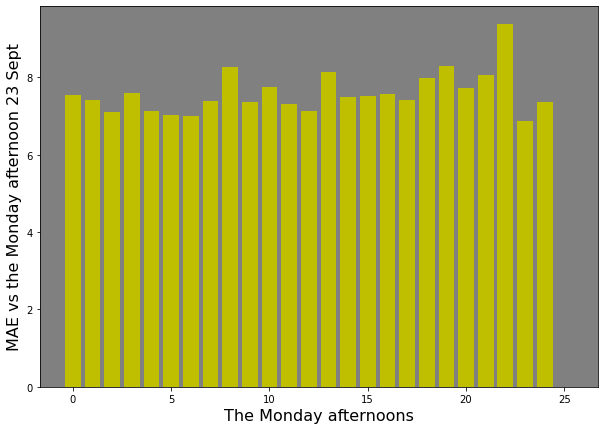

In [37]:
df = congestion_monday_afternoon
scores=[]
for idx in df.columns:
    score = 0
    for time_id in range(36):
        score +=mean_absolute_error(df[idx][(time_id*65):((time_id+1)*65)].astype(int), df[df.columns[-1]][(time_id*65):((time_id+1)*65)].astype(int))
    scores.append(score/36.0)

plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The Monday afternoons', fontsize=16)
plt.ylabel('MAE vs the Monday afternoon 23 Sept', fontsize=16)
plt.show()

## Pontuação entre o congestionamento das tardes de segunda-feira w.r.t. o congestionamento médio
### O erro absoluto médio entre todas as tardes de segunda-feira e o congestionamento médio em todas as tardes é mostrado abaixo.

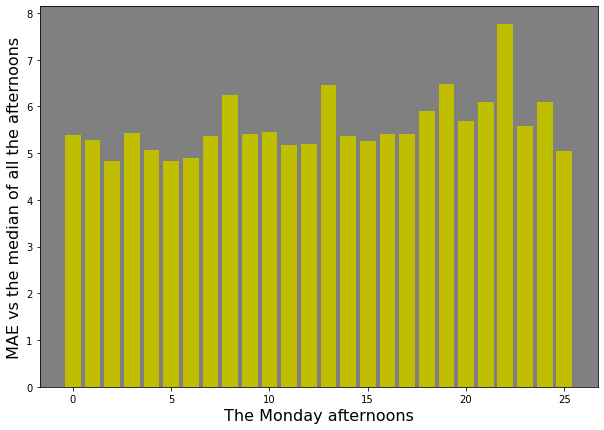

In [38]:
df = congestion_afternoon
df_monday = congestion_monday_afternoon
scores=[]
for idx in df_monday.columns:
    score =mean_absolute_error(df_monday[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The Monday afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

## Pontuação entre o congestionamento das tardes
### O erro absoluto médio entre todas as tardes e a tarde mais próxima do teste (29 de setembro) é mostrado abaixo.

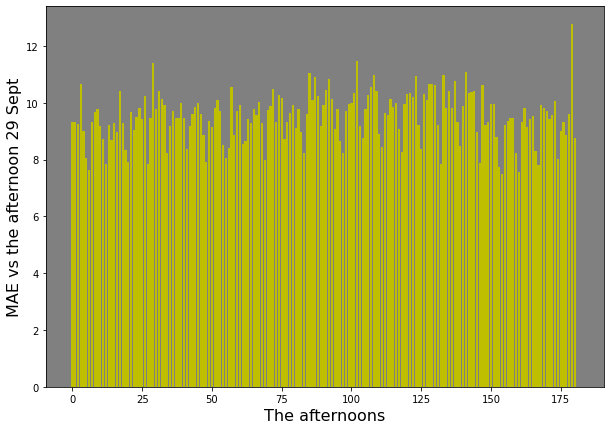

In [39]:
df = congestion_afternoon
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), df[df.columns[-1]].astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the afternoon 29 Sept', fontsize=16)
plt.show()

## Pontuação entre o congestionamento das tardes w.r.t. o congestionamento médio
### O erro absoluto médio entre todas as tardes e o congestionamento mediano em todas as tardes é mostrado abaixo.

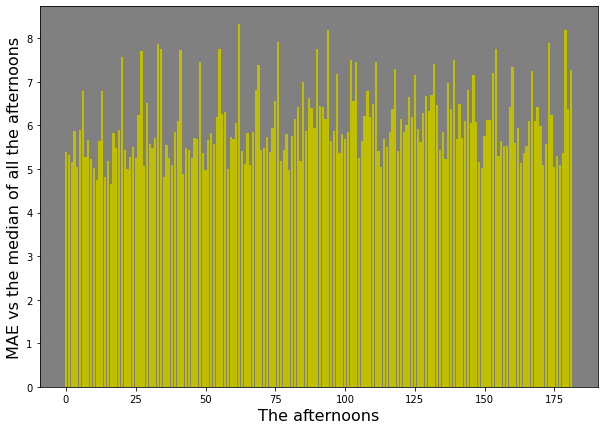

In [40]:
df = congestion_afternoon
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

## valores atípicos

### Podemos considerar as tardes com alto MAE w.r.t. o congestionamento mediano como outliers.

In [41]:
df = congestion_afternoon
outliers=[]
outlier_days=[]
for idx in df.columns:
    if (mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int)) > 7):
        day_idx = idx //2 + 91
        
        outliers.append(idx)
        outlier_days.append(day_idx)
print(f'% outliers: {len(outliers)/len(df.columns)*100}')

% outliers: 15.934065934065933


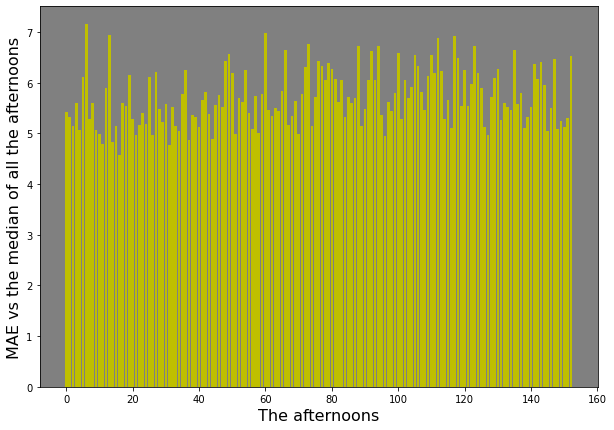

In [42]:
df = congestion_afternoon[[idx for idx in congestion_afternoon.columns if idx not in outliers]]
scores=[]
for idx in df.columns:
    score =mean_absolute_error(df[idx].astype(int), np.median(df, axis=1).round().astype(int))
    scores.append(score)
plt.figure(figsize=(10,7))
plt.bar(range(len(scores)),scores, color='y')
plt.xlabel('The afternoons', fontsize=16)
plt.ylabel('MAE vs the median of all the afternoons', fontsize=16)
plt.show()

## Linhas de base simples sem aprendizado de máquina
### Média diária

In [43]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [44]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('dailyMedian.csv', index=False)
submission.head()

,row_id,congestion
0,848835,47
1,848836,34
2,848837,50
3,848838,26
4,848839,71


## Média diária, excluir fim de semana

In [45]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df[df.time.dt.weekday<=4].groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [46]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('dailyMedianExcludeWeekend.csv', index=False)
submission.head()

,row_id,congestion
0,848835,50
1,848836,35
2,848837,54
3,848838,26
4,848839,72


## Média diária, remover valores discrepantes

In [47]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.x == x) & (train.y==y) & (train.direction==direction) & (~train.time.dt.dayofyear.isin(outlier_days))]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.median().tolist()[-36:]

In [48]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('dailyMedianRemoveOutliers.csv', index=False)
submission.head()

,row_id,congestion
0,848835,48
1,848836,35
2,848837,52
3,848838,27
4,848839,72


## Média de toda segunda-feira

### A linha de base abaixo simplesmente toma, para cada rodovia, a média do congestionamento de segunda-feira à tarde como uma previsão para a tarde de segunda-feira, 30 de setembro (veja a discussão).

In [49]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.time.dt.weekday==0) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.groupby(df.daytime_id).congestion.mean().tolist()[-36:]

In [50]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('MondayMean.csv', index=False)
submission.head()

,row_id,congestion
0,848835,46
1,848836,36
2,848837,55
3,848838,22
4,848839,72


## A segunda-feira mais próxima
### Podemos observar que a segunda-feira mais próxima (23 de setembro) se encaixa melhor com a segunda-feira 30 de setembro em comparação com a média de toda a segunda-feira. Portanto, também poderíamos considerar este dia como uma linha de base. Consideramos também uma média de janela (rolando) para reduzir a variância da previsão.

In [51]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train[(train.time.dt.dayofyear==test.time.dt.dayofyear.tolist()[0]-7) & (train.x == x) & (train.y==y) & (train.direction==direction)]
            
            if df.shape[0]>0:                
                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = df.congestion.rolling(10).mean()[-36:].tolist()

In [52]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('23SeptSmooth.csv', index=False)
submission.head()

,row_id,congestion
0,848835,48
1,848836,34
2,848837,41
3,848838,26
4,848839,64


## Xgboost

In [53]:
import xgboost as xgb

In [54]:
test['congestion'] = -1

for x in range(3):
    for y in range(4):
        for idx, direction in enumerate(train.direction.unique()):
            # extract data for each roadway
            df = train_new[(train_new.x == x) & (train_new.y==y) & (train_new.direction==direction)]
            df_new = pd.DataFrame()
            if df.shape[0]>0:                
                for idx, group in df.groupby(df.time.dt.dayofyear):
                    if len(group.congestion) == 72: # consider only days without missing data
                        df_new[f'day_{idx}'] = group.congestion.tolist()
            
                X_train = df_new[df_new.columns[:-1]][-36:]
                y_train = df_new[df_new.columns[-1]][-36:]

                X_test = df_new[df_new.columns[1:]][-36:]

                model = xgb.XGBRegressor(base_score=0.5,
                                  #booster='gbtree',
                                  colsample_bylevel=1,
                                  colsample_bynode=1,
                                  colsample_bytree=1,
                                  #enable_categorical=False,
                                  gamma=0,
                                  importance_type=None, 
                                  #interaction_constraints='',
                                  learning_rate=0.300000012,
                                  max_delta_step=0,
                                  max_depth=6,
                                  min_child_weight=1,
                                  #monotone_constraints='()',
                                  n_estimators=1000,
                                  n_jobs=-1,
                                  num_parallel_tree=1,
                                  #objective='multi:softprob',
                                  random_state=8780,
                                  reg_alpha=0,
                                  reg_lambda=1,
                                  scale_pos_weight=None,
                                  subsample=1,
                                  tree_method='auto',
                                  use_label_encoder=True,
                                  validate_parameters=1,
                                  verbosity=0)

                model.fit(X_train, y_train)
                #model = xgb.XGBRegressor(n_estimators=100000,
                                    #learning_rate=0.3,
                                    #subsample=0.5,
                                    #colsample_bytree=1, 
                                    #max_depth=6)
                #model.fit(X_train, y_train)

                test.congestion[(test.x == x) & (test.y==y) & (test.direction==direction)] = model.predict(X_test).tolist()

In [55]:
submission.congestion = test.congestion.round().astype(int).tolist()
submission.congestion[submission.congestion<0] = 0
submission.congestion[submission.congestion>100] = 100
submission.to_csv('XgboostRegression1.csv', index=False)
submission.head()

,row_id,congestion
0,848835,45
1,848836,41
2,848837,54
3,848838,17
4,848839,59
